In [1]:
from utils import *
import episcanpy.api as epi
import time
import umap

2024-02-29 13:42:13.996232: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 13:42:16.085914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-29 13:42:18.971056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Read data

In [32]:
file_path = '../data/E13_5-S1_atac.h5ad'

adata_raw = sc.read_h5ad(file_path)
adata_raw.obs['label'] = adata_raw.obs['Annotation_for_Combined']
print('load data: ', adata_raw)

epi.pp.filter_features(adata_raw, min_cells=1)
epi.pp.filter_cells(adata_raw, min_features=1)
num_all_peak = adata_raw.n_vars
print('data after pre-filtering: ', adata_raw)

load data:  AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes

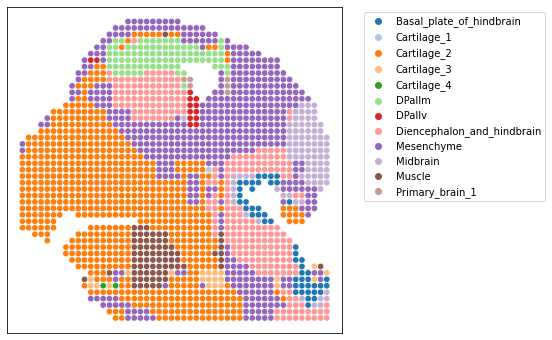

In [33]:
coord_x = np.array(adata_raw.obsm['spatial'][:,0])
coord_y = -np.array(adata_raw.obsm['spatial'][:,1])
plt.figure(figsize=(6, 6))
sns.scatterplot(x=coord_x, y=coord_y, hue=adata_raw.obs['label'], palette='tab20', s=40)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Set parameters

In [34]:
save_path = '../result/mouse_brain'
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_select_peak = 10000
seed_base = 1
tf = 'tfidf2'
pc = 10
k = 20
similarity = 'cosine'
iter_time = 4
spmethod = 'threshold'
neighbor = 5
sp_dist = 'recip'
pre_select = 'highest'
peaks_num = 50000
distance = 'euclidean'
r = 0.4

# Run Descartes

In [35]:
start_time = time.time()

adata = sc.AnnData(adata_raw.X,dtype = 'float32')
idx, sorted_index, simi_matrix, idx_all, scores, selected_peaks_data,similarity_matrix_acb, similarity_matrix_spatial = run_descartes(adata_raw, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

end_time = time.time()

AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_Mito

# Save the results

In [6]:
result = pd.DataFrame({'idx':idx})
filename = save_path + '/Descartes.csv'
result.to_csv(filename,header=True)

In [7]:
current_pid = os.getpid()
peak_memory = get_peak_memory_usage(current_pid)
run_time = end_time - start_time
meta = pd.DataFrame({'Peak memory':[peak_memory], 'run time':[run_time]})
meta.to_csv(save_path + '/Descartes_meta.csv',index=None)

# Analysis

## Overlap with domain-specific peaks identified by epiScanpy

In [8]:
sparse_matrix = scipy.sparse.csr_matrix(adata_raw.X)
adata_temp = anndata.AnnData(X=sparse_matrix)
adata_temp.obs['label'] = list(adata_raw.obs['Annotation_for_Combined'])
adata_temp.var_names = adata_raw.var_names
label = np.array(adata_temp.obs['label'])
label[np.where(label == 'Cartilage_1')[0]] = 'Cartilage_2'
adata_temp.obs['label'] = label
adata_temp.X = sc.pp.log1p(adata_temp.X)
adata_temp.raw = adata_temp
epi.tl.rank_features(adata_temp, 'label')
adata_temp


    			When the parameters where not specified in input


AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'label'
    uns: 'rank_features_groups'

In [9]:
a = np.array(adata_temp.uns['rank_features_groups']['names'].tolist())
domains = list(adata_temp.uns['rank_features_groups']['names'].dtype.names)
c = pd.DataFrame(a,columns=domains)
d = []
for domain in domains:
    b = list(c[domain])
    d.append(list(adata_raw.var_names.get_indexer(b)))
d = pd.DataFrame(np.array(d).T,columns=domains)
c, d

(    Basal_plate_of_hindbrain                Cartilage_2  \
 0       chr7:4123629-4124130   chr4:124708675-124709176   
 1     chr7:79525769-79526270    chr10:80260940-80261441   
 2   chr3:108433510-108434011     chr2:32317962-32318463   
 3   chr2:150643943-150644444    chr17:39843120-39843621   
 4     chr6:91301763-91302264   chr9:106356245-106356746   
 ..                       ...                        ...   
 95  chr8:124284228-124284729    chr11:74832081-74832582   
 96  chr4:154948216-154948717   chr7:113513425-113513926   
 97      chr1:5023194-5023695     chr5:34187588-34188089   
 98    chr1:34583718-34584219  chr11:109011651-109012152   
 99  chr4:140658105-140658606      chr19:8966769-8967270   
 
                   Cartilage_3               Cartilage_4  \
 0      chr2:33977596-33978097    chr7:37496483-37496984   
 1     chr11:38060130-38060631   chr16:77754716-77755217   
 2    chr2:172844886-172845387  chr5:135442428-135442929   
 3       chr16:8871329-8871830   chr15

In [10]:
overlap = []
for domain in domains:
    a = c[domain]
    b = d[domain]
    overlap.append(np.intersect1d(np.array(idx), b).size / len(a))
result = pd.DataFrame({'domain':domains,'overlap':overlap})
result

,domain,overlap
0,Basal_plate_of_hindbrain,0.98
1,Cartilage_2,0.97
2,Cartilage_3,0.03
3,Cartilage_4,0.04
4,DPallm,0.93
5,DPallv,0.46
6,Diencephalon_and_hindbrain,0.56
7,Mesenchyme,0.83
8,Midbrain,0.85
9,Muscle,0.90


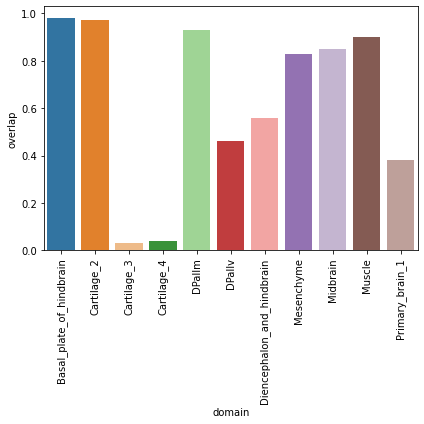

In [11]:
colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94']
sns.set_palette(colors)
plt.figure(figsize=(6, 6))
sns.barplot(x='domain', y='overlap',data=result)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Clustering

In [36]:
num_all_peak = adata_raw.n_vars

count = tfidf2(adata_raw.X.todense().T).T
print(count.shape)

count_filter = count[:,idx]
count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(np.array(count_filter))
adata_pca = sc.AnnData(scipy.sparse.csc_matrix(count_filter),dtype = 'float32')
adata_pca.obs['label'] = list(adata_raw.obs['label'])

sc.pp.neighbors(adata_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
leiden_df = run_leiden(adata_pca,'label','cluster',seed=int(seed_base*1000))

leiden_df

(1777, 271126)
Clustering...
resolution: 0.1, NMI: 0.4812918873946111, ARI: 0.5426417695676197, Homo: 0.39402373096918775, AMI: 0.47877244034495325
resolution: 0.2, NMI: 0.5069968824472592, ARI: 0.39091636392435297, Homo: 0.5207145161675039, AMI: 0.501658982269791
resolution: 0.3, NMI: 0.4805971233149587, ARI: 0.2910632249667228, Homo: 0.5366214804525727, AMI: 0.47374720645974217
resolution: 0.4, NMI: 0.5003872898447786, ARI: 0.3182760110840682, Homo: 0.5669231004232631, AMI: 0.4931753000547969
resolution: 0.5, NMI: 0.47723649527141515, ARI: 0.2630050703825569, Homo: 0.5671639329707595, AMI: 0.4685184541668516
resolution: 0.6, NMI: 0.47710296714550626, ARI: 0.24850035388497296, Homo: 0.5768958516618459, AMI: 0.46846519413964516
resolution: 0.7, NMI: 0.4918109302703362, ARI: 0.24555584198406158, Homo: 0.6199730858041148, AMI: 0.48173250672467194
resolution: 0.8, NMI: 0.483638423719809, ARI: 0.2318242604611739, Homo: 0.6193165396071002, AMI: 0.472885004207663
resolution: 0.9, NMI: 0.4785

,resolution,NMI,ARI,Homo,AMI
0,0.2000,0.506997,0.390916,0.520715,0.501659
1,0.5625,0.489992,0.268630,0.586715,0.481510
2,0.1000,0.481292,0.542642,0.394024,0.478772
3,0.2000,0.506997,0.390916,0.520715,0.501659
4,0.3000,0.480597,0.291063,0.536621,0.473747
5,0.4000,0.500387,0.318276,0.566923,0.493175
6,0.5000,0.477236,0.263005,0.567164,0.468518
7,0.6000,0.477103,0.248500,0.576896,0.468465
8,0.7000,0.491811,0.245556,0.619973,0.481733
9,0.8000,0.483638,0.231824,0.619317,0.472885


In [40]:
adata_pca.obsm['spatial'] = adata_raw.obsm['spatial']
sc.pp.neighbors(adata_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
leiden_df = run_leiden_(adata_pca,'label','cluster',seed=int(seed_base*1000),n_cluster=np.unique(adata_raw.obs['label']).shape[0])
sc.pp.neighbors(adata_pca, n_neighbors=90, use_rep='spatial',random_state=seed_base*1000)

adata_pca.obsm['X_emb'] = scipy.sparse.csc_matrix(count_filter)
LISI = lisi_graph_py(adata=adata_pca, group_key='cluster')    
print('LISI:',np.median(LISI))

CHAOS = fx_CHAOS(np.array(adata_pca.obs['cluster'],dtype=int),np.array(adata_pca.obsm['spatial']))
print('CHAOS:',CHAOS)

PAS = fx_PAS(np.array(adata_pca.obs['cluster'],dtype=int),np.array(adata_pca.obsm['spatial']))
print('PAS:',PAS)

Clustering...
LISI: 3.410472060494635
CHAOS: 0.0886324843882515
PAS: 0.34440067529544177


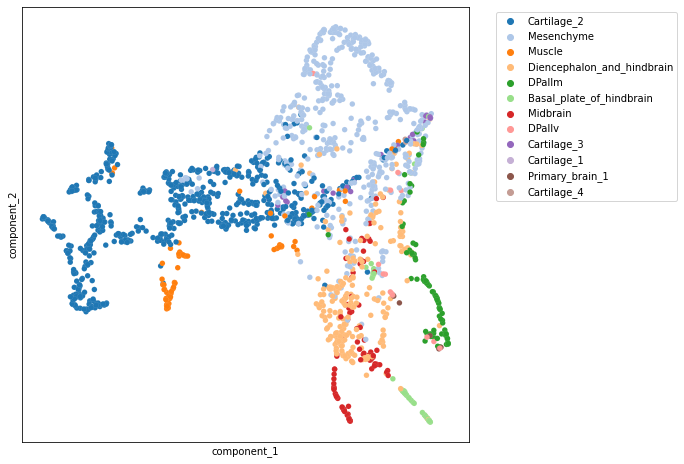

In [41]:
label = adata_pca.obs['label']
proj = umap.UMAP().fit_transform(count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'component_1':proj[:, 0],\
    'component_2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="component_1", y="component_2", hue="label",palette = 'tab20', s=30,linewidth = 0.05, data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([])
plt.yticks([])
plt.show()

# Applications

## Data imputation

In [14]:
data_enhance = scale(simi_matrix @ selected_peaks_data)
data_enhance.shape

(1777, 10000)

In [15]:
count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(np.array(data_enhance))
adata_pca = sc.AnnData(scipy.sparse.csc_matrix(count_filter),dtype = 'float32')
adata_pca.obs['label'] = list(adata_raw.obs['label'])

sc.pp.neighbors(adata_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
leiden_df = run_leiden(adata_pca,'label','cluster',seed=int(seed_base*1000))

leiden_df

Clustering...
resolution: 0.1, NMI: 0.5507485184060299, ARI: 0.44659636324213475, Homo: 0.543682034803692, AMI: 0.5457635745791729
resolution: 0.2, NMI: 0.5100753542676343, ARI: 0.37033630503382514, Homo: 0.5472594761988047, AMI: 0.5041745055996871
resolution: 0.3, NMI: 0.47128052956078875, ARI: 0.23863804652950626, Homo: 0.5655099602243624, AMI: 0.4624853703635891
resolution: 0.4, NMI: 0.47891242029519915, ARI: 0.20693481377014206, Homo: 0.6136276907280485, AMI: 0.4686721913074149
resolution: 0.5, NMI: 0.474026220429642, ARI: 0.18419454433539767, Homo: 0.6343036778966934, AMI: 0.46213142636849786
resolution: 0.6, NMI: 0.4752297412393157, ARI: 0.17198119895762623, Homo: 0.6563437465489618, AMI: 0.4624242135215891
resolution: 0.7, NMI: 0.48092279982137176, ARI: 0.1679420454015638, Homo: 0.6736187493105751, AMI: 0.4677903649483701
resolution: 0.8, NMI: 0.4794839085532978, ARI: 0.1683126566623197, Homo: 0.6704122575174217, AMI: 0.4663286545421277
resolution: 0.9, NMI: 0.48092279982137165,

,resolution,NMI,ARI,Homo,AMI
0,0.100000,0.550749,0.446596,0.543682,0.545764
1,0.269531,0.493077,0.290038,0.590896,0.484634
2,0.100000,0.550749,0.446596,0.543682,0.545764
3,0.200000,0.510075,0.370336,0.547259,0.504175
4,0.300000,0.471281,0.238638,0.565510,0.462485
5,0.400000,0.478912,0.206935,0.613628,0.468672
6,0.500000,0.474026,0.184195,0.634304,0.462131
7,0.600000,0.475230,0.171981,0.656344,0.462424
8,0.700000,0.480923,0.167942,0.673619,0.467790
9,0.800000,0.479484,0.168313,0.670412,0.466329


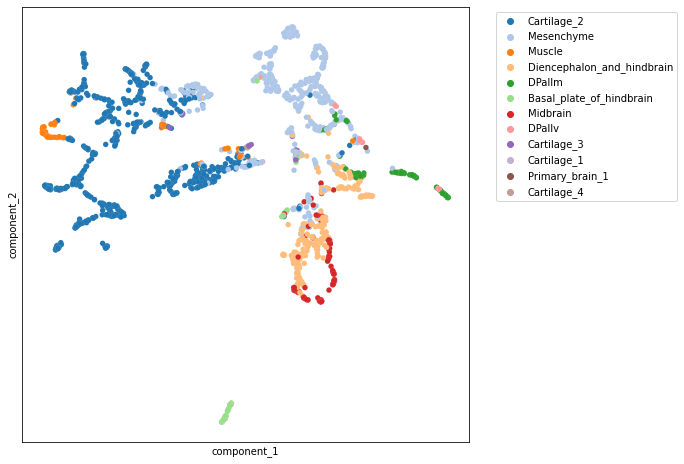

In [16]:
label = adata_pca.obs['label']
proj = umap.UMAP().fit_transform(count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'component_1':proj[:, 0],\
    'component_2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
ax = sns.scatterplot(x="component_1", y="component_2", hue="label",palette = 'tab20', s=30,linewidth = 0.05, data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([])
plt.yticks([])
plt.show()

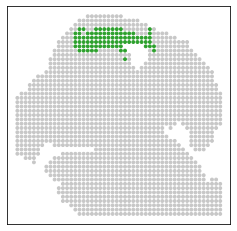

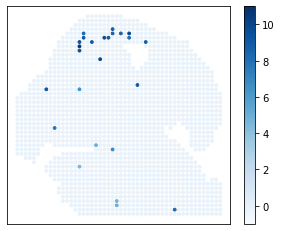

In [40]:
select_domain = np.where(adata_raw.obs['label'] == 'DPallm')[0]
no_select_domain = np.where(adata_raw.obs['label'] != 'DPallm')[0]
label = np.array(adata_raw.obs['label'])
label[select_domain] = '#2ca02c'
label[no_select_domain] = '#c7c7c7'
adata_raw.obs['label_new'] = label

plt.figure(figsize=(4,4))
coord_x = np.array(adata_raw.obsm['spatial'][:,0])
coord_y = -np.array(adata_raw.obsm['spatial'][:,1])
plt.scatter(coord_x, coord_y, s=8, c=label)
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(5,4))
accs = selected_peaks_data[:,6488]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=8, cmap='Blues',vmin=-1,vmax=11)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

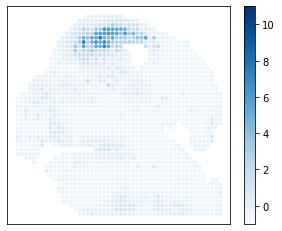

In [41]:
plt.figure(figsize=(5,4))
accs = data_enhance[:,6488]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=8, cmap='Blues',vmin=-1,vmax=11)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Peak module identification

In [17]:
start_time = time.time()
pdist_ = peak_modules_(selected_peaks_data=selected_peaks_data, similarity_matrix=simi_matrix, method='complete')
pdist_ = (pdist_+pdist_.T)/2
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")
print("Peak modules calculation has been done.")

pdist_.shape

Running time: 2.598972 seconds
Peak modules calculation has been done.


(10000, 10000)

In [18]:
non_diagonal_values = pdist_[np.triu_indices(pdist_.shape[0], k=1)]
peak_similarity = np.copy(pdist_)
thd = np.percentile(non_diagonal_values, 99.5)
peak_similarity[peak_similarity > thd] = thd
peak_distance = thd - peak_similarity
np.fill_diagonal(peak_distance, 0)
peak_distance

array([[    0.        ,  5467.32607645,  4656.58217091, ...,
        15622.65786035, 16038.94440328, 16396.17880856],
       [ 5467.32607645,     0.        ,  3955.57562243, ...,
        11773.19234895, 11909.45926563, 13170.93507692],
       [ 4656.58217091,  3955.57562243,     0.        , ...,
        10698.74490126, 11046.46065148, 12415.61032444],
       ...,
       [15622.65786035, 11773.19234895, 10698.74490126, ...,
            0.        ,     0.        ,     0.        ],
       [16038.94440328, 11909.45926563, 11046.46065148, ...,
            0.        ,     0.        ,     0.        ],
       [16396.17880856, 13170.93507692, 12415.61032444, ...,
            0.        ,     0.        ,     0.        ]])

Cluster labels: [6 4 6 ... 1 1 1]


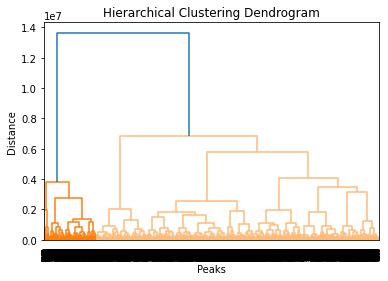

Number 1: Count = 153, Proportion = 1.53%
Number 2: Count = 1410, Proportion = 14.10%
Number 3: Count = 1522, Proportion = 15.22%
Number 4: Count = 3160, Proportion = 31.60%
Number 5: Count = 1416, Proportion = 14.16%
Number 6: Count = 1187, Proportion = 11.87%
Number 7: Count = 587, Proportion = 5.87%
Number 8: Count = 565, Proportion = 5.65%


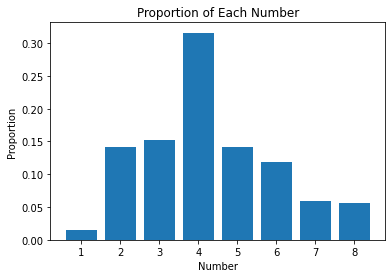

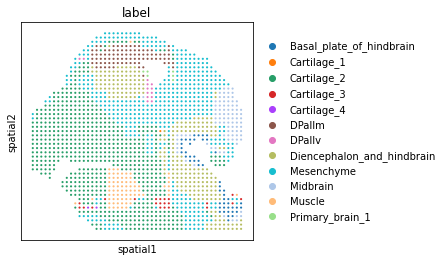

Number of peaks in module 1: 153
Visualize peak module of label 1:
9999


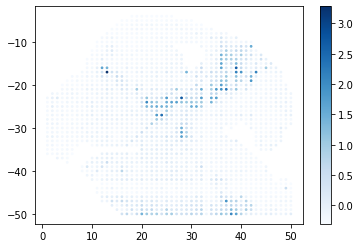

Number of peaks in module 2: 1410
Visualize peak module of label 2:
9999


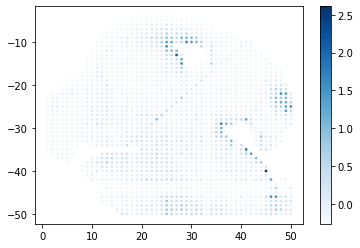

Number of peaks in module 3: 1522
Visualize peak module of label 3:
9999


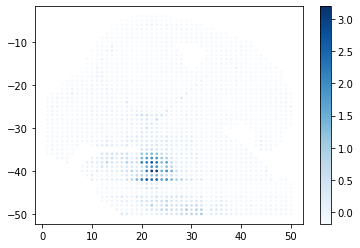

Number of peaks in module 4: 3160
Visualize peak module of label 4:
9999


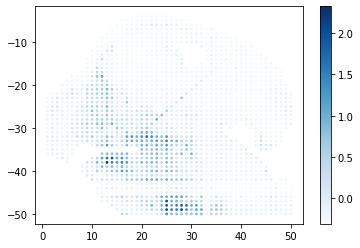

Number of peaks in module 5: 1416
Visualize peak module of label 5:
9999


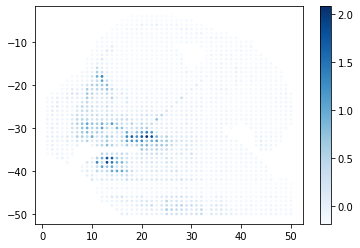

Number of peaks in module 6: 1187
Visualize peak module of label 6:
9999


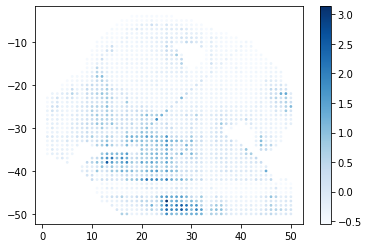

Number of peaks in module 7: 587
Visualize peak module of label 7:
9999


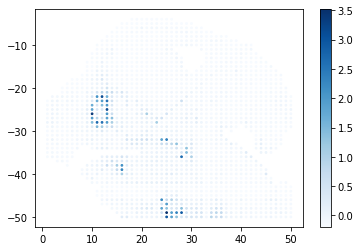

Number of peaks in module 8: 565
Visualize peak module of label 8:
9999


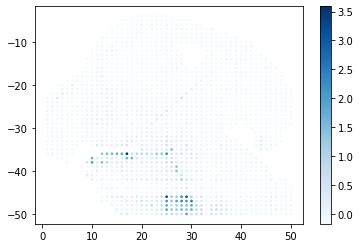

In [19]:
Z,labels = peak_module_cluster(adata_raw,idx,peak_distance,"ward",num_clusters = 8)

In [27]:
labels_temp = labels.copy()
labels_temp[labels == 4] = 9
labels_temp[labels == 5] = 4
labels_temp[labels == 6] = 5
labels_temp[labels == 7] = 6
labels_temp[labels == 8] = 7
labels_temp[labels == 4] = 8
labels = labels_temp

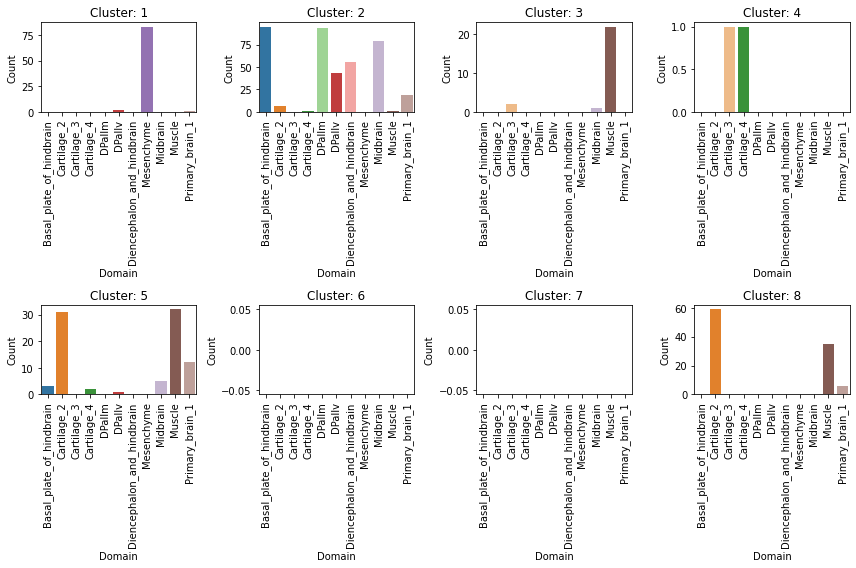

In [28]:
colors = ['#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94']
sns.set_palette(colors)

result = []
cluster = pd.DataFrame({'idx':idx, 'label':labels})
for i in np.unique(labels):
    data_new = cluster[cluster['label'] == i]
    idx_new = set(list(data_new['idx']))
    result_i = []
    for key in d.keys():
        idx_key = set(list(d[key]))
        result_i.append(len(idx_key.intersection(idx_new)))
    result.append(result_i)
result = pd.DataFrame(np.array(result).T)
result.index = d.keys()
result.columns = ['1','2','3','4','5','6','7','8']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

for i, cluster in enumerate(result.columns):
    row, col = divmod(i, 4)
    sns.barplot(x=result.index, y=result[cluster], ax=axes[row, col])
    axes[row, col].set_title(f'Cluster: {cluster}')
    axes[row, col].set_xticklabels(result.index, rotation=90)
    axes[row, col].set_xlabel('Domain')
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [29]:
from scipy.cluster.hierarchy import leaves_list

pdist_z = scale(pdist_)
pdist_z = (pdist_z + pdist_z.T) / 2
results_z = pd.DataFrame(pdist_z)

ii = leaves_list(Z)
results_z = results_z.iloc[ii, ii]

label_indexed = pd.DataFrame(results_z, index=range(len(labels)))

# 按照labels的顺序重新排列行
sorted_results_z = label_indexed.loc[np.argsort(labels), np.argsort(labels)]
sorted_results_z

,9999,9015,659,696,803,8727,922,8530,8500,8426,...,7750,2800,1409,7753,7754,7756,2803,1407,5586,1107
9999,14.476394,9.112882,7.882280,5.788968,6.655483,8.866765,5.747101,8.556184,9.521926,8.528422,...,-3.327355,-2.562170,-1.919966,-3.624630,-4.877162,-3.847049,-2.687430,-3.034716,-2.635041,-5.911748
9015,9.112882,5.338840,4.846087,4.059998,4.372894,5.672135,4.475859,5.415946,5.334111,5.383827,...,-1.211453,-0.634420,-0.506562,-1.731589,-1.957102,-1.493708,-0.794904,-1.267968,-0.767361,-2.504818
659,7.882280,4.846087,4.183275,4.026110,4.374305,5.099464,3.525071,5.302626,4.345610,4.272121,...,-0.889417,-0.655752,-0.453170,-1.299480,-1.491961,-1.378223,-0.663756,-0.862516,-0.824307,-1.682968
696,5.788968,4.059998,4.026110,3.629805,2.076052,3.961942,3.701911,4.580175,3.194832,3.874146,...,-0.421220,-0.355804,0.010335,-0.781744,-1.302176,-1.079573,0.024233,-0.335983,-0.278231,-1.410916
803,6.655483,4.372894,4.374305,2.076052,4.388102,4.426593,2.647228,3.991514,3.486962,3.586508,...,-0.606327,-0.597512,0.134288,-0.874709,-1.201111,0.045636,-0.540877,-0.976514,-0.541438,-1.375193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7756,-3.847049,-1.493708,-1.378223,-1.079573,0.045636,-1.519163,-0.931043,-1.659503,-1.767397,-1.293313,...,1.077144,0.301955,1.011468,1.270341,1.413224,1.919059,0.428250,0.332296,0.710505,0.829387
2803,-2.687430,-0.794904,-0.663756,0.024233,-0.540877,-0.851961,-0.255797,-0.641746,-0.905795,-0.631613,...,0.358730,0.173232,0.240999,0.703061,0.842940,0.428250,1.001953,1.207698,1.110694,0.415941
1407,-3.034716,-1.267968,-0.862516,-0.335983,-0.976514,-1.204705,-0.504641,-0.698915,-1.212753,-0.586566,...,0.431888,0.071182,-0.634265,-0.063136,0.632460,0.332296,1.207698,1.329655,1.439592,-0.146472
5586,-2.635041,-0.767361,-0.824307,-0.278231,-0.541438,-1.078232,-0.175150,-0.631425,-0.854573,-0.736653,...,0.761756,0.585333,-0.016958,0.622847,0.840657,0.710505,1.110694,1.439592,1.369947,0.154605


In [30]:
name_map = {}
next_mod = 1
for i in sorted_results_z.index:
    mod = labels[i]
    if mod in name_map:
        continue
    if mod == -1:
        continue
    else:
        name_map[int(mod)] = "Module {}".format(next_mod)
        next_mod = next_mod + 1
name_map[-1] = "Module 0"

name_map_r = {v: k for k, v in name_map.items()}
name_map, name_map_r

({1: 'Module 1',
  2: 'Module 2',
  3: 'Module 3',
  4: 'Module 4',
  5: 'Module 5',
  6: 'Module 6',
  7: 'Module 7',
  8: 'Module 8',
  -1: 'Module 0'},
 {'Module 1': 1,
  'Module 2': 2,
  'Module 3': 3,
  'Module 4': 4,
  'Module 5': 5,
  'Module 6': 6,
  'Module 7': 7,
  'Module 8': 8,
  'Module 0': -1})

In [31]:
colors = sns.color_palette("muted")
colormap = {i: colors[i % 10] if i != -1 else (1.0, 1.0, 1.0) for i in np.unique(labels)}
colormap_r = {v: k for k, v in colormap.items()}
row_colors1 = pd.Series(
    [colormap[i] for i in labels],
    index=range(10000),
)

row_colors = pd.DataFrame({"Module": row_colors1})
row_colors = row_colors.loc[sorted_results_z.index]

cmap = sns.diverging_palette(230, 20, sep=20, s=85, l=50, as_cmap=True)

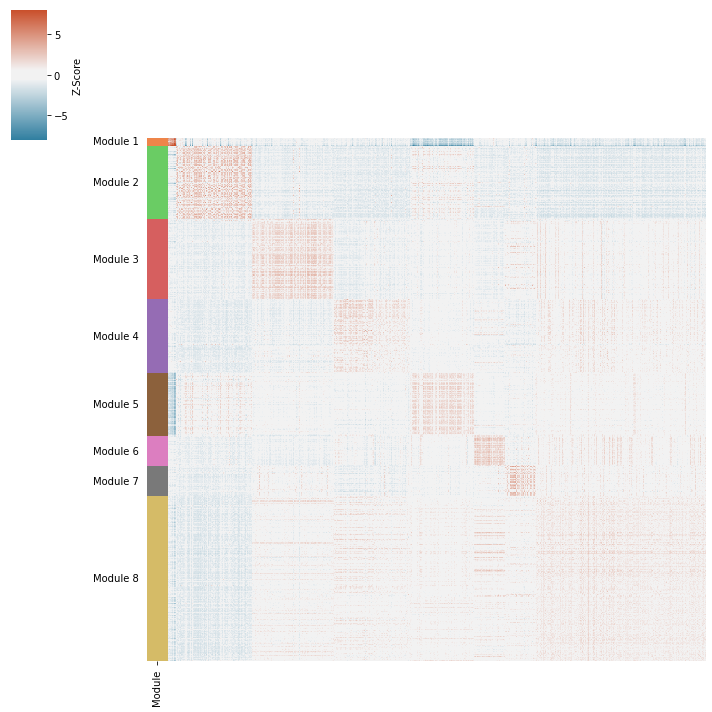

In [32]:
cm = sns.clustermap(
    sorted_results_z,
    row_cluster=False,
    col_cluster=False,
    vmin=-8,
    vmax=8,
    cmap=cmap,
    xticklabels=False,
    yticklabels=False,
    row_colors=row_colors,
    rasterized=True,
    cbar_kws=dict(
        label="Z-Score",
#         ticks=[-8, 0, 8],
    ),
)

fig = plt.gcf()
fig.patch.set_visible(False)
plt.sca(cm.ax_heatmap)
plt.ylabel("")
plt.xlabel("")

# Assuming row_colors is ordered, label the groups
plt.sca(cm.ax_row_colors)
for i in row_colors.Module.unique():
    if i == (1.0, 1.0, 1.0):
        continue
    mid = 0
    count = 0
    cl = colormap_r[i]
    for j, x in enumerate(row_colors.Module.values):
        if x == i:
            mid += j
            count += 1

    mid = mid/count

    plt.text(-.4, mid, name_map[cl],
             horizontalalignment='right',
             verticalalignment='center')

plt.show()

## Linking gene expression patterns to chromatin accessibility

In [3]:
file_path = '../data/'
dataset = 'E13_5-S1'
atac = sc.read_h5ad(file_path + dataset + '_atac' + '.h5ad')
atac.X = scipy.sparse.csc_matrix(atac.X)
atac.obs['label'] = atac.obs['Annotation_for_Combined']
 
expr = sc.read_h5ad(file_path + dataset + '_expr' + '.h5ad')
expr.X = scipy.sparse.csc_matrix(expr.X)
expr.obs['label'] = expr.obs['Annotation_for_Combined']
expr.var_names_make_unique()

barcode_set1 = set(atac.obs_names)
barcode_set2 = set(expr.obs_names)

common_barcodes = barcode_set1.intersection(barcode_set2)

atac = atac[atac.obs_names.isin(common_barcodes), :]
expr = expr[expr.obs_names.isin(common_barcodes), :]
expr = expr[atac.obs_names]

sc.pp.normalize_total(expr, target_sum=1e4)
sc.pp.log1p(expr)

count_mat = atac.X.todense().T
tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
ATAC_count = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1]))))
atac.X = scipy.sparse.csc_matrix(ATAC_count.T)

atac, expr

(View of AnnData object with n_obs × n_vars = 1777 × 271126
     obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes',

In [8]:
seed_base = 1
tf = None
pc = 10
k = 20
similarity = 'cosine'
iter_time = 4
spmethod = 'threshold'
neighbor = 5
sp_dist = 'recip'
pre_select = 'highest'
peaks_num = 50000
distance = 'euclidean'
r = 0.4

num_select_peak = 20000
idx_atac, _, _, _, _, _,_, _ = run_descartes(atac, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

num_select_peak = 2000
idx_expr, _, _, _, _, _,_, _ = run_descartes(expr, num_select_peak, seed_base=seed_base, tfidf=tf, ifPCA=True, pc=pc, k=k, similarity=similarity, iters=iter_time, spmethod=spmethod,neighbor=neighbor,sp_dist=sp_dist, pre_select=pre_select, peaks_num=peaks_num, distance=distance,r=r)

idx_atac.shape, idx_expr.shape

View of AnnData object with n_obs × n_vars = 1777 × 271126
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', '

scores:
[ 1360.11132006  1360.7918667   1361.05247691 ...  9721.80179624
 10502.08018652 16742.92872856]
(1777, 1777)
(1777, 10)
0.0
compute scores


scores:
[ 1360.7924703   1361.05337661  1362.98779098 ...  9723.40960841
 10502.10826597 16742.21451982]
(1777, 1777)
(1777, 10)
0.0
compute scores


scores:
[ 1360.06397625  1360.7896044   1361.17522231 ...  9722.16085053
 10502.56595495 16743.79672805]
(1777, 1777)
(1777, 10)
0.0
compute scores


scores:
[ 1360.06177242  1360.79076807  1361.59935494 ...  9721.97536577
 10501.96821632 16743.95899041]


((20000,), (2000,))

In [9]:
idx_atac,idx_expr

(array([ 93636,  71343,  99634, ..., 141754, 213344, 141755]),
 array([28839,   715, 13489, ..., 21534, 25966, 28049]))

In [10]:
file_path = '../data/'
dataset = 'E13_5-S1'
atac = sc.read_h5ad(file_path + dataset + '_atac' + '.h5ad')
atac.X = scipy.sparse.csc_matrix(atac.X)
atac.obs['label'] = atac.obs['Annotation_for_Combined']
 
expr = sc.read_h5ad(file_path + dataset + '_expr' + '.h5ad')
expr.X = scipy.sparse.csc_matrix(expr.X)
expr.obs['label'] = expr.obs['Annotation_for_Combined']
expr.var_names_make_unique()

barcode_set1 = set(atac.obs_names)
barcode_set2 = set(expr.obs_names)

common_barcodes = barcode_set1.intersection(barcode_set2)

atac = atac[atac.obs_names.isin(common_barcodes), :]
expr = expr[expr.obs_names.isin(common_barcodes), :]
expr = expr[atac.obs_names]

atac_20000 = atac[:,idx_atac]
expr_2000 = expr[:,idx_expr]
atac_20000,expr_2000

(View of AnnData object with n_obs × n_vars = 1777 × 20000
     obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 

In [11]:
sc.pp.normalize_total(expr_2000, target_sum=10000)
sc.pp.log1p(expr_2000)
sc.pp.scale(expr_2000)
expr_2000

AnnData object with n_obs × n_vars = 1777 × 2000
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoRa

In [12]:
count_mat = atac_20000.X.toarray().T
tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
ATAC_count = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / np.sum(count_mat,axis=1)).reshape(-1,1), (1,count_mat.shape[1]))))
atac_20000.X = scipy.sparse.csc_matrix(ATAC_count.T)
atac_20000

View of AnnData object with n_obs × n_vars = 1777 × 20000
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'G

In [13]:
adata = anndata.concat([atac_20000, expr_2000], axis=1)
adata.obs['label'] = list(atac_20000.obs['label'])
adata.obsm['spatial'] = atac_20000.obsm['spatial']
adata

AnnData object with n_obs × n_vars = 1777 × 22000
    obs: 'label'
    obsm: 'spatial'

In [16]:
adata.X = scipy.sparse.csc_matrix(adata.X)

ATAC_count_test = scale(adata.X.toarray())
count = ATAC_count_test.copy()
print(count.shape)
    
similarity_matrix_acb = np.zeros([count.shape[0], count.shape[0]])
similarity_matrix_spatial = np.zeros([count.shape[0], count.shape[0]])

distance_matrix = np.zeros([count.shape[0], count.shape[0]])
print(distance_matrix.shape)

count = PCA(n_components=pc,random_state=int(seed_base*1000)).fit_transform(count)
print(count.shape)
if similarity == 'Jaccard':
    if distance == 'euclidean':
        diff = count[:, np.newaxis, :] - count[np.newaxis, :, :]
        distance_matrix = np.linalg.norm(diff, axis=2)
        np.fill_diagonal(distance_matrix, np.inf)
    elif distance == 'cosine':
        count_norm = np.linalg.norm(count, axis=1, keepdims=True)
        dot_product_matrix = np.dot(count, count.T)
        distance_matrix = 1 - dot_product_matrix / (count_norm * count_norm.T)
        np.fill_diagonal(distance_matrix, np.inf)

distance_matrix_acb = np.copy(distance_matrix)

spatial_data = adata.obsm['spatial']
diff = spatial_data[:, np.newaxis, :] - spatial_data[np.newaxis, :, :]
distance_matrix = np.linalg.norm(diff, axis=2)
np.fill_diagonal(distance_matrix, np.inf)
distance_matrix_spatial = np.copy(distance_matrix)

similarity_matrix_acb = np.zeros([count.shape[0], count.shape[0]])
similarity_matrix_spatial = np.zeros([count.shape[0], count.shape[0]])
if spmethod == 'threshold':
    min_dist = np.min(distance_matrix_spatial)
    if sp_dist == 'const':
        similarity_matrix_spatial = np.array(distance_matrix_spatial <= neighbor * min_dist,dtype=int)
    elif sp_dist == 'recip':
        similarity_matrix_spatial = min_dist / distance_matrix_spatial
        similarity_matrix_spatial = similarity_matrix_spatial * (distance_matrix_spatial <= neighbor * min_dist)
    else:
        similarity_matrix_spatial = (min_dist / distance_matrix_spatial)**2
        similarity_matrix_spatial = similarity_matrix_spatial * (distance_matrix_spatial <= neighbor * min_dist)

elif spmethod == 'SNN':
    neighbor_index = np.argsort(distance_matrix_spatial, axis=1)[:,0:k]
    if similarity == "Jaccard":
        for i in range(count.shape[0]):
            for j in range(i):
                intersect_num = len(np.intersect1d(neighbor_index[i,:], neighbor_index[j,:]))
                similarity_matrix_spatial[i][j] = 1.0*intersect_num/(2*k-intersect_num)
                similarity_matrix_spatial[j][i] = 1.0*intersect_num/(2*k-intersect_num)
if similarity == "Jaccard":
    neighbor_index = np.argsort(distance_matrix_acb, axis=1)[:,0:k]
    for i in range(count.shape[0]):
        for j in range(i):
            intersect_num = len(np.intersect1d(neighbor_index[i,:], neighbor_index[j,:]))
            similarity_matrix_acb[i][j] = 1.0*intersect_num/(2*k-intersect_num)
            similarity_matrix_acb[j][i] = 1.0*intersect_num/(2*k-intersect_num)
elif similarity == "cosine":
    similarity_matrix_acb = sklearn.metrics.pairwise.cosine_similarity(count)
    for i in range(count.shape[0]):
        similarity_matrix_acb[i][i] = -float('inf')
    neighbor_index = np.argsort(similarity_matrix_acb, axis=1)[:,0:(count.shape[0]-k)]
    for i in range(count.shape[0]):
        similarity_matrix_acb[i,neighbor_index[i,:]] = 0
    print(similarity_matrix_acb[0,0])

similarity_matrix = (1 - r) * similarity_matrix_acb + r*similarity_matrix_spatial


print('compute scores')
scores = np.zeros(adata.n_vars)
X_processed = ATAC_count_test

temp_matrix = np.matmul(similarity_matrix, X_processed)
scores = np.sum(X_processed * temp_matrix, axis=0)
sorted_index = np.argsort(scores)
idx = sorted_index[::-1]
print('scores:')
print(scores[idx])

(1777, 22000)
(1777, 1777)
(1777, 10)
0.0
compute scores
scores:
[27063.35616578 24208.65285974 23381.88111058 ...   122.00724002
    68.20435685    64.67631549]


In [18]:
start_time = time.time()
pdist_ = peak_modules_(selected_peaks_data=X_processed, similarity_matrix=similarity_matrix, method='complete')
pdist_ = (pdist_+pdist_.T)/2
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.6f} seconds")
print("Peak modules calculation has been done.")

pdist_.shape

Running time: 11.892456 seconds
Peak modules calculation has been done.


(22000, 22000)

In [20]:
g_p_similarity = pdist_[20000:,:20000]

### The most likely gene and peak

In [21]:
index = np.unravel_index(np.argmax(g_p_similarity, axis=None), g_p_similarity.shape)
index

(1999, 19996)

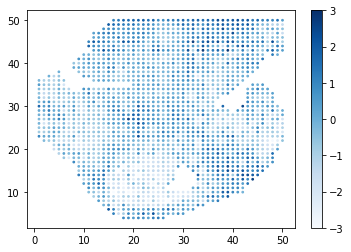

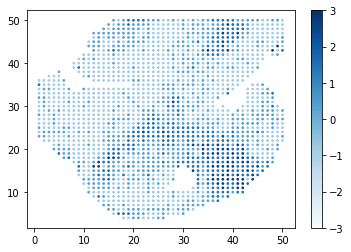

In [23]:
accs = expr_2000.X[:,index[0]]
coord_x = np.array(atac_20000.obsm['spatial'][:,0])
coord_y = np.array(atac_20000.obsm['spatial'][:,1])
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

accs = scale(atac_20000.X.toarray())[:,index[1]]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

### Gene to peak

In [24]:
expr_matrix = expr_2000.X
atac_matrix = scale(atac_20000.X.toarray())
expr_matrix.shape, atac_matrix.shape

((1777, 2000), (1777, 20000))

In [25]:
a = anndata.AnnData(scipy.sparse.csc_matrix(atac_matrix))
a.obs_names = list(atac.obs_names)
a.obs['label'] = list(atac.obs['label'])
a.obsm['spatial'] = atac.obsm['spatial']

b = anndata.AnnData(scipy.sparse.csc_matrix(expr_matrix))
b.obs_names = list(expr.obs_names)
b.obs['label'] = list(expr.obs['label'])
b.obsm['spatial'] = expr.obsm['spatial']

result = np.zeros_like(g_p_similarity)
for col in range(g_p_similarity.shape[1]):
    indices = np.argpartition(g_p_similarity[:, col], -20)[-20:]
    result[indices, col] = g_p_similarity[indices, col]
    
    indices = np.argpartition(g_p_similarity[:, col],5)[:5]
    result[indices, col] = g_p_similarity[indices, col]
result.shape

(2000, 20000)

In [26]:
atac_matrix_pred = expr_matrix @ result
atac_matrix_pred = scale(atac_matrix_pred)
atac_matrix_pred.shape

(1777, 20000)

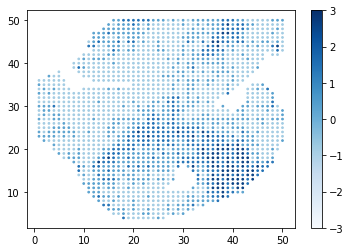

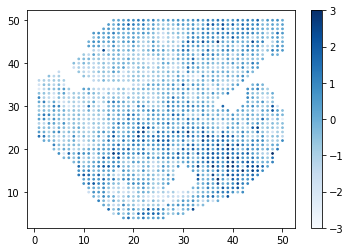

In [27]:
accs = atac_matrix[:,19998]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

accs = atac_matrix_pred[:,19998]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

### Peak to gene

In [28]:
g_p_similarity_T = g_p_similarity.T
result = np.zeros_like(g_p_similarity_T)
for col in range(g_p_similarity_T.shape[1]):
    indices = np.argpartition(g_p_similarity_T[:, col], -20)[-20:]
    result[indices, col] = g_p_similarity_T[indices, col]
    
    indices = np.argpartition(g_p_similarity_T[:, col],5)[:5]
    result[indices, col] = g_p_similarity_T[indices, col]
result.shape

(20000, 2000)

In [29]:
expr_matrix_pred = atac_matrix @ result
expr_matrix_pred = scale(expr_matrix_pred)
expr_matrix_pred.shape

(1777, 2000)

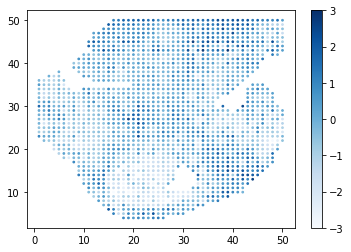

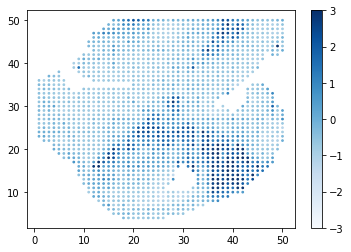

In [30]:
accs = expr_matrix[:,1999]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()

accs = expr_matrix_pred[:,1999]
accs = np.array(accs)
accs = np.squeeze(accs)
plt.scatter(coord_x, coord_y, c=accs, s=3, cmap='Blues',vmin=-3, vmax=3)
plt.colorbar()
plt.show()